In [81]:
from pillow_lut import identity_table, rgb_color_enhance
from PIL import Image, ImageFilter
from IPython.display import display
import pandas as pd
import numpy as np

# Introduction to LUTs
3D Look Up Tables (LUT)s are a common method to transform the colors of an images globally. \
For each possible RGB color a LUT tells you which color to map it to. 

A LUT might speficy that all green pixels in an image should be yellow: 

Input pixel RGB values: \
(0,255,0) \
would map to: \
(255,255,0) 

In a standard 8-bit image, each channel (R,G,B) can take values from 0 to 255. In theory a LUT should therefore have a mapping for every possible color - that would be 256 x 256 x 256 colors or entries in our look up table. \
As these files would be quite large and processing would be complex LUTs are usually way smaller. An 8-bit (8 x 8 x 8) LUT would divide each channel into ranges of 32 (256 divided by 8). \
Since we have 3 channels (red, green and blue), our LUT can be imagined as a three dimensional cube:


<img src="3dlut-standard.svg" width="500" height="600">

To apply a LUT to the image, each color in the image is assigned to one of the cells in the LUT cube, and the color of the pixel in the original image is changed to whatever RGB color is in its assigned cell in the LUT cube. Hence the color (12, 0, 0) would belong to the second cell along the red axis in the top left corner of the cube. This also means that all the shades of red between (8, 0, 0) and (15, 0, 0) will be mapped to the same RGB color. Though that sounds terrible, an 8-bit LUT usually produces images that are fine to our eyes. Of course we can increase the “quality” of the resulting image by using a more precise (eg: 12-bit) LUT. 

Source: https://kevinmartinjose.com/2021/04/27/film-simulations-from-scratch-using-python/

## How mapping works
To understand 3D LUTs in further detail we are going to perform a couple of experiments in practice. First of all we are going to look at how the values of a simple LUT look like. \
For simplicity we are going to create a very small LUT with a resolution of just 3 bits. We are going to create an identity LUT, which is a LUT that maps the input values to the same values, which means the image looks the same after processing.

The low resolution of just 3 bits means that this LUT would divide each channel into ranges of ~85 (256 divided by 8) which means that:
- values from 0 to 85 would be mapped to 0
- values from 86 to 171 would be mapped to 128
- values from 172 to 256 would be mapped to 256

The values within a LUT are in range 0 to 1. Therefore we must imagine the pixel values in this range: 0 would be 0.0, 128 would be 0.5 and 256 would be 1.

We use `Pillow LUT tools` to create LUTs: https://pillow-lut-tools.readthedocs.io/en/latest/

In [264]:
# Create 3 bit identity LUT
identity_lut_3bit = identity_table(3)

In [261]:
# Convert LUT to a pandas DataFrame
rgb_values = pd.DataFrame(identity_lut_3bit.table.reshape(-1,3), columns=["Orig_B", "Orig_G", "Orig_R"])
rgb_values["Maps to:"] = ""
lut_df = pd.DataFrame(identity_lut_3bit.table.reshape(-1,3), columns=["R", "G", "B"])

mapping_df = rgb_values.join(lut_df)
print(mapping_df.to_string(index=False))

 Orig_B  Orig_G  Orig_R Maps to:   R   G   B
    0.0     0.0     0.0          0.0 0.0 0.0
    0.5     0.0     0.0          0.5 0.0 0.0
    1.0     0.0     0.0          1.0 0.0 0.0
    0.0     0.5     0.0          0.0 0.5 0.0
    0.5     0.5     0.0          0.5 0.5 0.0
    1.0     0.5     0.0          1.0 0.5 0.0
    0.0     1.0     0.0          0.0 1.0 0.0
    0.5     1.0     0.0          0.5 1.0 0.0
    1.0     1.0     0.0          1.0 1.0 0.0
    0.0     0.0     0.5          0.0 0.0 0.5
    0.5     0.0     0.5          0.5 0.0 0.5
    1.0     0.0     0.5          1.0 0.0 0.5
    0.0     0.5     0.5          0.0 0.5 0.5
    0.5     0.5     0.5          0.5 0.5 0.5
    1.0     0.5     0.5          1.0 0.5 0.5
    0.0     1.0     0.5          0.0 1.0 0.5
    0.5     1.0     0.5          0.5 1.0 0.5
    1.0     1.0     0.5          1.0 1.0 0.5
    0.0     0.0     1.0          0.0 0.0 1.0
    0.5     0.0     1.0          0.5 0.0 1.0
    1.0     0.0     1.0          1.0 0.0 1.0
    0.0   

The dataframe shows how input values would be mapped to new values by our created identity LUT. As this is an identity LUT the output value is always equal to the input value. \
For example a pixel with the RGB values 0,0,0 would be mapped to 0,0,0 again.

### Black an white LUT
In this next step we are going to look at a lut that actually manipulates the image. With the `rgb_color_enhance` function of `Pillow LUT tools` we create a LUT that turns the saturation of the image to 0 / \
transforms the image to a black and white image.

In [169]:
bw_lut = rgb_color_enhance(3, saturation=-1)

In [260]:
bw_lut_df = pd.DataFrame(bw_lut.table.reshape(-1,3), columns=["R", "G", "B"])

bw_mapping_df = rgb_values.join(bw_lut_df)
print(bw_mapping_df.to_string(index=False))

 Orig_B  Orig_G  Orig_R Maps to:      R      G      B
    0.0     0.0     0.0          0.0000 0.0000 0.0000
    0.5     0.0     0.0          0.1063 0.1063 0.1063
    1.0     0.0     0.0          0.2126 0.2126 0.2126
    0.0     0.5     0.0          0.3576 0.3576 0.3576
    0.5     0.5     0.0          0.4639 0.4639 0.4639
    1.0     0.5     0.0          0.5702 0.5702 0.5702
    0.0     1.0     0.0          0.7152 0.7152 0.7152
    0.5     1.0     0.0          0.8215 0.8215 0.8215
    1.0     1.0     0.0          0.9278 0.9278 0.9278
    0.0     0.0     0.5          0.0361 0.0361 0.0361
    0.5     0.0     0.5          0.1424 0.1424 0.1424
    1.0     0.0     0.5          0.2487 0.2487 0.2487
    0.0     0.5     0.5          0.3937 0.3937 0.3937
    0.5     0.5     0.5          0.5000 0.5000 0.5000
    1.0     0.5     0.5          0.6063 0.6063 0.6063
    0.0     1.0     0.5          0.7513 0.7513 0.7513
    0.5     1.0     0.5          0.8576 0.8576 0.8576
    1.0     1.0     0.5     

Now we can see that the output values differ from the input values. For example an pixel with the RGB values 128, 256, 0, which would normalized to the range between 0 and 1, be: 0.5,1,0 \
would be mapped to the RGB values: 0.8215, 0.8215, 0.8215

We can also see that the R,G,B values are always identical for one entry, which is typical for black and white images as they only display variation in brightness and not in color.

### Map all pixels to red with a 3D look up table
To get a further understanding of 3D LUTs lets create a LUT that maps all pixels, no matter what input RGB values a pixel has, to red. \
Every entry in our look up table should therefore be: 1,0,0 (R,G,B)

In [256]:
red = [1.,0.,0.]

In [257]:
# Create the entire LUT with 3bit resolution:
red_LUT = np.array(red*27) # 3x3x3 LUT = 27 entries

In [259]:
red_lut_df = pd.DataFrame(red_LUT.reshape(-1,3), columns=["R", "G", "B"])

red_mapping_df = rgb_values.join(red_lut_df)
print(red_mapping_df.to_string(index=False))

 Orig_B  Orig_G  Orig_R Maps to:   R   G   B
    0.0     0.0     0.0          1.0 0.0 0.0
    0.5     0.0     0.0          1.0 0.0 0.0
    1.0     0.0     0.0          1.0 0.0 0.0
    0.0     0.5     0.0          1.0 0.0 0.0
    0.5     0.5     0.0          1.0 0.0 0.0
    1.0     0.5     0.0          1.0 0.0 0.0
    0.0     1.0     0.0          1.0 0.0 0.0
    0.5     1.0     0.0          1.0 0.0 0.0
    1.0     1.0     0.0          1.0 0.0 0.0
    0.0     0.0     0.5          1.0 0.0 0.0
    0.5     0.0     0.5          1.0 0.0 0.0
    1.0     0.0     0.5          1.0 0.0 0.0
    0.0     0.5     0.5          1.0 0.0 0.0
    0.5     0.5     0.5          1.0 0.0 0.0
    1.0     0.5     0.5          1.0 0.0 0.0
    0.0     1.0     0.5          1.0 0.0 0.0
    0.5     1.0     0.5          1.0 0.0 0.0
    1.0     1.0     0.5          1.0 0.0 0.0
    0.0     0.0     1.0          1.0 0.0 0.0
    0.5     0.0     1.0          1.0 0.0 0.0
    1.0     0.0     1.0          1.0 0.0 0.0
    0.0   

As we can see above, no matter what RGB values a pixel would have, it would always be mapped to 100% red. \
We will demonstrate this later in the Notebook.

## Application of a LUT to an image with PIL
Now lets see the effect the LUTs have on a sample image. First of all we pick an image from our training data:

In [164]:
# Example image
image = Image.open("../fuji_images/JPG/256x256/DSCF2607.JPG")

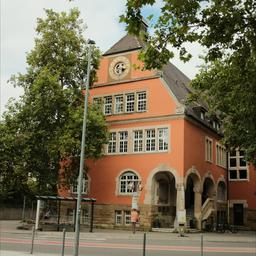

In [165]:
display(image)

We could simply use the PIL `.filter` function to apply a LUT to an image. As we described earlier, in theory we would need a 256-bit LUT to map all possible pixel values to new values via a LUT. \
With smaller LUTs we are forced to map different colors to the same new color entry in the LUT, which can decrease the quality of an image and its color transitions / resolution. \
To avoid this problem a common method is to use interpolation on the nearest elements.  

As we can see below, even though our LUT is just a very low resoluted 3-bit LUT and it is theoretically necessary to map around 85 different colors to one new color, the image still looks normal at this scale thanks to interpolation.

Source: https://pillow.readthedocs.io/en/stable/reference/ImageFilter.html

In [167]:
identitiy_image = image.filter(identity_lut_3bit)

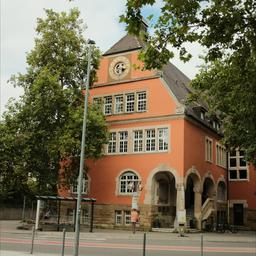

In [168]:
display(identitiy_image)

### Interpolation
Interpolation uses the input signals and the extracted lattice points that contain the
destination specifications to calculate the destination color specifications for the
input point. \
(The *extracted lattice points* are the specific RGB values that are represented in the LUT) 

Nonlattice points are interpolated by using the nearest lattice points. This is the
step where the extraction performs a search to select the lattice points necessary
for computing the destination specification of the input point.

This can be done with four geometrical interpolations methods: trilinear, prism, pyramid, and tetrahedral. \
For our models in the following notebooks we will use the trilinear approach. \
Source: https://spie.org/samples/PM159.pdf 

Interpolation is generally great, because it helps to improve the quality of the processed images even though the LUTs are very small files.
But for our use case to truly see the effect different LUTs with different resolutions have on an image, \
we want to implement our own function that applies the LUT directly without any interpolation. \
The manual implementation should also deepen our understanding of LUTs.

# Manual application of the LUT
To apply the LUT directly without interpolation we have to map RGB values of the image manually to the corresponding values in the LUT. \
As only a LUT with size 256 would include a mapping for all RGB values we have to get the bins / indexes we want to map our RGB values to for our smaller LUTs.

Once again, we use our 3-bit identity LUT as our starting point:

In [201]:
lut_data=identity_lut_3bit.table.reshape((3, 3, 3, 3))
print(lut_data)

[[[[0.  0.  0. ]
   [0.5 0.  0. ]
   [1.  0.  0. ]]

  [[0.  0.5 0. ]
   [0.5 0.5 0. ]
   [1.  0.5 0. ]]

  [[0.  1.  0. ]
   [0.5 1.  0. ]
   [1.  1.  0. ]]]


 [[[0.  0.  0.5]
   [0.5 0.  0.5]
   [1.  0.  0.5]]

  [[0.  0.5 0.5]
   [0.5 0.5 0.5]
   [1.  0.5 0.5]]

  [[0.  1.  0.5]
   [0.5 1.  0.5]
   [1.  1.  0.5]]]


 [[[0.  0.  1. ]
   [0.5 0.  1. ]
   [1.  0.  1. ]]

  [[0.  0.5 1. ]
   [0.5 0.5 1. ]
   [1.  0.5 1. ]]

  [[0.  1.  1. ]
   [0.5 1.  1. ]
   [1.  1.  1. ]]]]


We take one pixel from our sample image to think about how it should be processed:
- First of all we normalize the image to values between 0 and 1 as this is the value range of our LUT
- Then we take one pixel as an example
- For this pixel we want to get the indexes to get the entry in the look up table the pixel should be mapped to

In [265]:
img_array = np.array(image.convert("RGB"), dtype=np.float32) / 255.0 # Range 0 to 1

In [220]:
# Get a pixel from the image array
img_array[70][100]

array([0.87058824, 0.6039216 , 0.42745098], dtype=float32)

As we do have a 3 bit LUT that does not have entries for all pixel values we have to map these values to the corresponding "bins". \
First we get the unique values that represent the bins. For a 3-bit LUT these are 0, 0.5 and 1 as we can see below.

As we explained in the beginning an identity LUT maps the pixels so that input equals output. That also means that we can use the identity LUT to get the indexes in the look up table as it represents the available values in the given LUT resolution.

In [202]:
bin_values = np.array(list(set(identity_lut_3bit.table)))
bin_values = np.sort(bin_values)
print(bin_values)

[0.  0.5 1. ]


To be able to map the pixels RGB values to a value of the 3D LUT we have to get indexes for its values:

For our example pixel we would expect to get the following indexes:
- R: 0.87058824 - should be index = 2 as 1 is the closest value
- G: 0.6039216  - should be index = 1 as 0.5 is the closest value
- B: 0.42745098 - should be index = 1 as 0.5 is the closest value

The function `find_nearest_lut_index` returns the index of the nearest bin value:

In [221]:
def find_nearest_lut_index(bin_values, value):
    return np.abs(bin_values - value).argmin()

find_nearest_lut_index(bin_values, 0.6039216)

1

As we can see above, if we test the function with the green value of 0.6039216 we do indeed get the index of 1.

In [227]:
pixel = img_array[70][100]
r_idx = find_nearest_lut_index(bin_values, pixel[0])
g_idx = find_nearest_lut_index(bin_values, pixel[1])
b_idx = find_nearest_lut_index(bin_values, pixel[2])
print(f"Indexes for R,G,B: {r_idx, g_idx, b_idx}")

Indexes for R,G,B: (2, 1, 1)


As expected the function returns the indexes 2,1,1 for the RGB values of our example pixel.

When testing the manual application of the LUT we figured out that we have to reference it like this:\
lut\[blue_index, green_index, red_index] \
which means the indexes are in `BGR` instead of `RGB` order.

In [225]:
# We determined the indexes for our sample index to be:
# R:2, G:1, B:1
# Reformatted to BGR:
# B:1, G:1, R:2

print(f"Using a 3bit identity LUT the pixel with the value: {img_array[70][100]}")
# Get the RGB value the pixel would be mapped to:
print(f"Would be mapped to the value: {lut_data[1, 1, 2]}")

Using a 3bit identity LUT the pixel with the value: [0.87058824 0.6039216  0.42745098]
Would be mapped to the value: [1.  0.5 0.5]


As we can see in the output above the value of our pixel would result in the new RGB values 1, 0.5, 0.5. This demonstrates the color resolution loss with very small LUTs as our 3-bit LUT. \
We can see that red is stil the strongest color in our pixel. The blue and green values are now equal, even though they differt ahead of processing. Overall we see a significant loss in color resolution.

### Apply LUT wihout interpolation
Now that we have explained the processing of a single pixel with a 3D LUT we created the function `apply_lut_without_interpolation` to see how the processing with LUTs affects all pixels of our image.

In [245]:
def apply_lut_without_interpolation(image, lut, identity_lut, lut_size=3, reshape=True):
    if reshape:
        lut_data = lut.table.reshape((lut_size, lut_size, lut_size, 3))
    else:
        lut_data = lut
    # Normalize image to values between 0 and 1
    img_array = np.array(image.convert("RGB"), dtype=np.float32) / 255.0
    
    
    # Get the indexes by getting the index values from the identity LUT
    bin_values = np.array(list(set(identity_lut.table)))
    bin_values = np.sort(bin_values)
    
    # Apply the LUT without interpolation
    mapped_img = np.zeros_like(img_array)
    
    for i in range(img_array.shape[0]):  # Loop over each row
        for j in range(img_array.shape[1]):  # Loop over each column
            r, g, b = img_array[i, j]  # Get the normalized RGB values

            #print(f"R:{r},G:{g},B:{b}")
            # Find the nearest LUT indices for R, G, and B
            r_idx = find_nearest_lut_index(bin_values, r)
            g_idx = find_nearest_lut_index(bin_values, g)
            b_idx = find_nearest_lut_index(bin_values, b)
            #print(f"R:{r_idx},G:{g_idx},B:{b_idx}")
            # Map the input color to the corresponding LUT output
            mapped_img[i, j] = lut_data[b_idx, g_idx, r_idx]
            #print(lut_data[r_idx, g_idx, b_idx])
    
    # Convert the mapped image back to 0, 255
    mapped_img = (mapped_img * 255).astype(np.uint8)
    
    # Convert to a PIL image and display
    filtered_image = Image.fromarray(mapped_img)
    return filtered_image

#### Apply 3-bit identity LUT
As a first experiment, lets apply our low resolution 3-bit LUT to our test image:

In [246]:
edited_image_3bit = apply_lut_without_interpolation(image, identity_lut_3bit, identity_lut_3bit, 3)

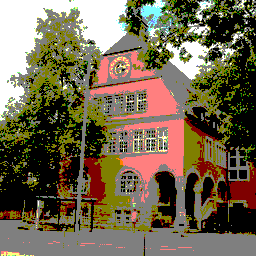

In [247]:
display(edited_image_3bit)

We can clearly see that without interpolation a 3-bit LUT significantly reduces the image quality. Basically the entirety of the front wall of our house in the test image is within the same shade of red, \
there are only very broken color transitions left.

#### Apply 33-bit identity LUT
If we increase the resolution of our LUT to 33-bit we can see that the image looks like the original image again:

In [248]:
identity_lut_33bit = identity_table(33)

In [249]:
edited_image_33bit = apply_lut_without_interpolation(image, identity_lut_33bit, identity_lut_33bit, 33)

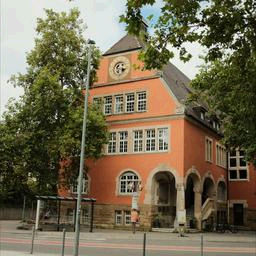

In [250]:
display(edited_image_33bit)

#### Apply 3-bit BW LUT
If we apply our 3-bit black and white LUT from earlier to our image we once again see broken transitions from the highlights to the shadows of the image, although not as bad as with a 3-bit color LUT:

In [251]:
bw_edited_image_3bit = apply_lut_without_interpolation(image, bw_lut, identity_lut_3bit, 3)

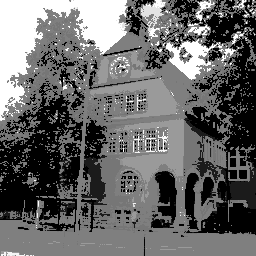

In [252]:
display(bw_edited_image_3bit)

#### Apply 3-bit red LUT
We previously created a LUT that maps all colors to 100% red no matter what the pixels original RGB values were, the result looks as expected: 

In [262]:
red_edited_image_3bit = apply_lut_without_interpolation(image, red_LUT.reshape(3,3,3,3), identity_lut_3bit, 3, reshape=False)

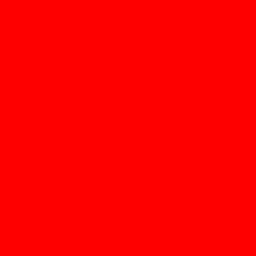

In [263]:
display(red_edited_image_3bit)

#### Create and apply red toned 8-bit LUT
As a last experiment lets create a LUT that transforms an image into a black and white like image but with a red tone.
The idea is that we add up the input pixel RGB values, which have maximum values of 1,1,1 and divide them by 3 to get the intensity of the red in the output pixel.

An input of 1,1,1 would lead to an output of 0,0,1 \
An input of 0,1,1 would lead to an output of 0,0,0.66 \
An input of 1,0,0 would lead to an output of 0,0,0.33 \

and so on...

We start with an 8 bit identity LUT:

In [267]:
identity_lut_8bit = identity_table(8)

We reshape the lut to get the RGB output values of the identity LUT:

In [268]:
identity_lut_8bit.table.reshape(-1,3)

array([[0.        , 0.        , 0.        ],
       [0.14285715, 0.        , 0.        ],
       [0.2857143 , 0.        , 0.        ],
       ...,
       [0.71428573, 1.        , 1.        ],
       [0.85714287, 1.        , 1.        ],
       [1.        , 1.        , 1.        ]], dtype=float32)

As the output values do also represent the possible input values of an 8-bit LUT we are going to use this LUT and iterate over its values. \
As explained before we are going to add up the values and divide them by 3 to get the value the red channel should have based on the input.

In [276]:
red_toned_8bit_LUT = []
for rgb_values in identity_lut_8bit.table.reshape(-1,3):
    red = sum(rgb_values)/3
    output = [red,0,0]
    red_toned_8bit_LUT.append(output)

In [280]:
red_toned_8bit_LUT=np.array(red_toned_8bit_LUT, dtype="float32")
red_toned_8bit_LUT

array([[0.        , 0.        , 0.        ],
       [0.04761905, 0.        , 0.        ],
       [0.0952381 , 0.        , 0.        ],
       ...,
       [0.9047619 , 0.        , 0.        ],
       [0.95238096, 0.        , 0.        ],
       [1.        , 0.        , 0.        ]], dtype=float32)

We can see that the green and blue channels are seemingly always 0, as we would expect, and we have different red values that should turn the image into a red toned version. 

In [282]:
red_edited_image_8bit = apply_lut_without_interpolation(image, red_toned_8bit_LUT.reshape(8,8,8,3), identity_lut_8bit, 8, reshape=False)

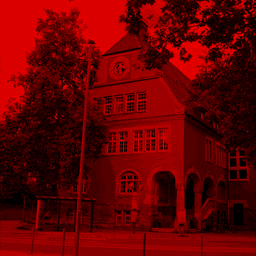

In [283]:
display(red_edited_image_8bit)

The image is successfully turned into a red toned version with our created 3D LUT! \
Hopefully it is comprehensible by now how 3D LUTs work and how images are processed with their help.